In [9]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import argparse
import json
import sys

In [1]:
def main():
    """
    Implements multiple linear modeling & multivariate modeling

    Inputs (multiple):
    Regressor pandas dataframe:
    6 motion params (demeaned), 1st derivatives of 6 motion parameters (deriv), 
    2 cardiac RETROICOR regressors, 2 resp RETROICOR regressors,
    1 HRV regressor, 1 RVT regressor

    Output (1):
    ICA component

    Linear Model:
    Y = MX + e
    Y = fit to ICA component time series (CxT) -> 1 dependent variable (prediction of fit to Y-variable)
    M = coefficient matrix you’re solving for (CxN) -> 
    X = all the above regressors and a row of ones for the intercept) (NxT) -> multiple independent variables
    e = error

    equation:  y = A+B1x1+B2x2+B3x3+B4x4

    C=# of components
    T=Time
    N=number of nuisance regressors
    """

    """
    sub=sub-01
    task=wnw
    run=1

    Parser call:
    python3 /Users/holnessmn/Desktop/BIDS_conversions/Linear_Model.py \
    --regressors /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/${sub}_RegressorModels_${task}_run-${run}.tsv \
    --ica_mixing /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/ica_mixing.tsv \
    --prefix /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/${sub}_LinearModel_${task}_run-${run}

    """

    parser = argparse.ArgumentParser()
    parser.add_argument("--regressors", dest="regressors", help="Regressor Model file", type=str)
    parser.add_argument("--ica_mixing", dest="ica_mixing", help="ICA mixing matrix", type=str)
    parser.add_argument("--prefix", dest="prefix", help="File Prefix & redirected output", type=str)

    ARG = parser.parse_args()

    if ARG.regressors and os.path.isfile(ARG.regressors):
        regress = ARG.regressors
    else:
        raise Exception(f"This file/filepath {ARG.regressors} does not exist!!!")

    if ARG.ica_mixing and os.path.isfile(ARG.ica_mixing):
        ica = ARG.ica_mixing
    else:
        raise Exception(f"This file/filepath {ARG.ica_mixing} does not exist!!!")

    if ARG.prefix and type(ARG.prefix) == str:
        prefix = ARG.prefix
    else:
        raise Exception(f"Not a string {ARG.prefix} !!!")


    # General question: How does each X-regressor (noise model) match each Y-comp (ICA component ts)?

    # Y-Data #
    # Read in the ICA components
    ica_tsv = pd.read_csv(ica, sep='\t')
    # ['ICA_00','ICA_01',...]
    ica_tsv.columns
    # multi-dimensional list with each component timeseries as sub-list, len = Num of timesteps/volumes
    icamix = ica_tsv.to_numpy()
    #icamixlist = [ica_tsv[i] for i in ica_tsv.columns]     

    print("Size of ICA mixing matrix: ", icamix.shape)

    # X-Data #
    # Read in the Noise Regressors          (24 noise regressors + intercept ts), len = 25
    regres_tsv = pd.read_csv(regress, sep='\t')
    # Regressor models ['cardiac_sin1','cardiac_cos1',...'WM_e','Csf_vent']
    regres_tsv.columns
    # multi-dimensional list with each regressor timeseries as sub-list, len = Num of timesteps/volumes (indexed by TRs...)
    noise_regress = regres_tsv.to_numpy()

    print(f"Size of noise regressors: {noise_regress.shape}")

    #visual_check(icamixlist, nphlmlist)
    
    # Fit the models and calculate signficance
    coefficient_matrix, R_sq, pvals = linear_model(icamixlist, nphlmlist)
    
    

    convert(coefficient_matrix, R_sq, pvals, prefix)
    significant_ICs()

def visual_check(icamixlist, nphlmlist):
    """
    Visual Check for each regressor model fit over each component

    Input: ICA mixing matrix, Regressor Models
    Output: Visual Plot of each Regressor Model (red) over each ICA component (blue)

    """

    # Iterate through each ICA component & Get Scores of Fit
    for idx, i in enumerate(icamixlist):

        # X = regressors models, Y = ica component, x.shape = (25,nvols), y.shape = (nvols)
        x, y = np.array(nphlmlist)[1:26], np.array(i)     # includes intercept of 1's

        # Iterate through each regressor
        for xi in x:

            # find significant p-value of each regressor (Xi) fit to component (y)
            sign = stats.linregress(xi, y).pvalue
            xi = xi.reshape(-1, 1)
            linear_model = LinearRegression().fit(xi, y)       # fit x-regressor data to y ica data

            # print summary of data:
            # intercept will be 0, bcuz sine wave (x,y modulate around 0)
            print("Coefficient of determination (R-sq): ", linear_model.score(xi, y), "Intercept: ", linear_model.intercept_, "Coefficients (scalar magnitudes): ", linear_model.coef_, "p-value: ", sign)     

            # plot the data -> ICA component (blue) = Y,  predicted ICA component based on (fitted to) X-regressor data
            plt.plot(y, 'b-')
            plt.plot(linear_model.predict(xi), 'r-')
            plt.legend(['ICA Component', 'Noise Regressor'], loc='best')
            plt.show()

            # Note: 
            # coefficient of determination -> will tell you how likely an ICA component is noise
            # coefficients -> will tell you which noise regressor model the ICA component matches


In [73]:
def linear_model(icamix, noise_regress):
    """
    Compute Linear Model

    Equation: Y = XB + E
    - Y = each ICA component
    - X = Design (Regressor) matrix
    - B = Weighting Factors (solving for B)
    - E = errors (Y - Y_pred OR Y - XB)

    Y1 = B0 + B1X4 + B2X5 + B3X6
    Yn = B0 + B1X1 + B2X2 + B3X3

    Y1 = (1 + X2 + X4 + X6) * (B0) + E1
    Yn = (1 + X1 + X3 + X5) * (B1) + E2
    (nx1)       (nx4)         (2x1) (nx1)

    Input: ICA mixing matrix, Regressor Models
    Output: Coefficient of determination (R-squared), B-Coefficients (list of scalar magnitudes)

    """
    #TODO make sure all noise_regress have the first two as slope and intercept or just remove them before running this program
    scaled_noise_regress = stats.zscore(noise_regress[:,2:], axis=0)
    print(scaled_noise_regress.shape)

    # initialize
    R_sq = np.zeros(icamix.shape[1])
    coefficient_matrix = np.zeros((icamix.shape[1], scaled_noise_regress.shape[1]))


    # get scores for each ICA component
    for idx in range(icamix.shape[1]):
        
        y = icamix[:,idx]

        # x as multiple input regressor array
        linear_model = LinearRegression().fit(scaled_noise_regress, y)       # fit x-regressor data to y ica data

        # append to coefficient matrix array (lower coefficient = higher match to model):
        coefficient_matrix[idx,:] = linear_model.coef_

        # append to coefficient of determination (R-sq) array:
        R_sq[idx] = linear_model.score(scaled_noise_regress, y)

        #TODO Add indexing
        # pvals = get_pval(linear_model, noise_regress, y)

        # print summary of data
        # intercept will be 0, bcuz sine wave (x,y modulate around 0)
        print("Coefficient of determination (R-sq): ", R_sq[idx], "Intercept: ", linear_model.intercept_, "Coefficients (scalar magnitudes): ", coefficient_matrix[idx,:])



    print("Coeff mat: ",coefficient_matrix, "R-sq: ",R_sq) #, "P-val: ",pvals)

    return coefficient_matrix, R_sq #, pvals

In [3]:
def get_pval(linear_model, X, y):
    """
    Calculation p values from linear model using code from:
    https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
    
    """

    params = np.append(linear_model.intercept_,linear_model.coef_)
    predictions = linear_model.predict(X)

    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0])) # mean squared error

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    print(p_values)
    return p_values

In [6]:
regressors="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/sub-01_RegressorModels_wnw_run-1.tsv"
ica_mixing="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/afniproc_orig/WNW/sub-01.results/tedana_kic_r01/ica_mixing.tsv"
prefix="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/tmp/testfits"
os.chdir("/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/tmp")

In [20]:
# Read in the ICA components
ica_tsv = pd.read_csv(ica_mixing, sep='\t')
# ['ICA_00','ICA_01',...]
ica_tsv.columns
icamix = ica_tsv.to_numpy()

print(f"Size of ICA mixing matrix: {icamix.shape}")

# X-Data #
# Read in the Noise Regressors          (24 noise regressors + intercept ts), len = 25
regres_tsv = pd.read_csv(regressors, sep='\t')
# Regressor models ['cardiac_sin1','cardiac_cos1',...'WM_e','Csf_vent']
regres_tsv.columns
# multi-dimensional list with each regressor timeseries as sub-list, len = Num of timesteps/volumes (indexed by TRs...)
noise_regress = regres_tsv.to_numpy()

print(f"Size of noise regressors: {noise_regress.shape}")


Size of ICA mixing matrix: (340, 57)
Size of noise regressors: (340, 26)


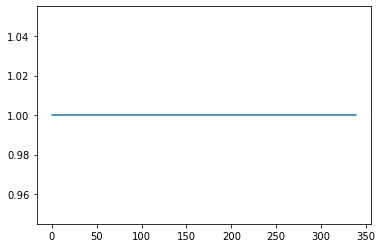

In [63]:
# plt.plot(icamix)
plt.plot(noise_regress[:,1])
plt.show()

In [74]:
coefficient_matrix, R_sq = linear_model(icamix, noise_regress)

(340, 24)
Coefficient of determination (R-sq):  0.13922921262701782 Intercept:  -5.2071420094017396e-17 Coefficients (scalar magnitudes):  [ 0.02976279 -0.63221708 -0.19398538  0.12098973  0.06399155 -0.42405732
 -0.1616692  -0.02640959  0.23649151 -0.28255818  0.17783704  0.22286924
 -0.05653222 -0.03355558 -0.04271943 -0.11168016 -0.16413665  0.09745217
 -0.02751154  0.08578284  0.05477419 -0.04591796  0.03550824  0.02217702]
Coefficient of determination (R-sq):  0.6593462184159034 Intercept:  -1.7727204328052048e-17 Coefficients (scalar magnitudes):  [-0.01116702  0.23936013 -0.12246027  0.01549157  0.07047345  0.33182807
 -0.20807939 -0.05528558 -0.11404517  0.39026     0.3393057  -0.12426844
 -0.05139804  0.06580734  0.07213215 -0.0608761  -0.15466891 -0.06495267
 -0.34481071 -0.17792621  0.00202424 -0.01783086  0.04408308 -0.0029273 ]
Coefficient of determination (R-sq):  0.341357375128431 Intercept:  -5.212566779234283e-17 Coefficients (scalar magnitudes):  [ 0.05371658 -0.32319

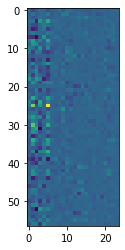

In [75]:
plt.imshow(coefficient_matrix) #[:,14:-1])
plt.show()

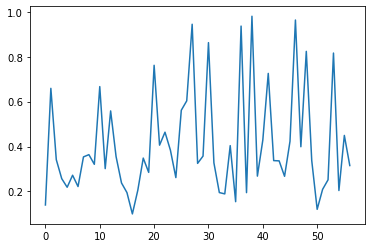

In [76]:
plt.plot(R_sq)
plt.show()